#Cell A — Imports & Paths

In [ ]:
# Cell A — Imports & Paths (Milestone 6)
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define base directories
PROJ = Path("/content/drive/MyDrive/player_value_prediction_project")
SANDBOX = PROJ / "data" / "processed" / "master" / "sandbox"

# Model outputs
paths = {
    "uni": SANDBOX / "models_lstm_univariate/lstm_univariate_predictions.csv",
    "mv": SANDBOX / "models_lstm_univariate/lstm_multivariate_predictions.csv",
    "mvtuned": SANDBOX / "models_lstm_univariate/lstm_multivariate_tuned_predictions.csv",
    "encdec": SANDBOX / "models_lstm/multivariate_tuned/encoder_decoder/encoder_decoder_predictions.csv",
    "lgbm": SANDBOX / "models_ensemble/lgbm_predictions.csv",
    "ensemble": SANDBOX / "models_ensemble/ensemble_predictions.csv"
}

print(" Project paths set")


 Project paths set


#Cell B — Load Predictions

In [ ]:
# Cell B — Load predictions from all models
preds = {}
for key, path in paths.items():
    if path.exists():
        df = pd.read_csv(path)
        preds[key] = df
        print(f"✅ Loaded {key}: {df.shape}, cols: {list(df.columns)[:6]}")
    else:
        print(f"⚠️ Missing {key} at {path}")

# Quick peek at ensemble (if exists)
if "ensemble" in preds:
    display(preds["ensemble"].head())


✅ Loaded uni: (6639, 4), cols: ['row_id', 'y_true', 'y_pred', 'target_year']
✅ Loaded mv: (6639, 4), cols: ['row_id', 'y_true', 'y_pred', 'target_year']
✅ Loaded mvtuned: (2109, 4), cols: ['row_id', 'y_true', 'y_pred', 'target_year']
✅ Loaded encdec: (1344, 8), cols: ['y_true_h1', 'y_true_h2', 'y_true_h3', 'y_pred_h1', 'y_pred_h2', 'y_pred_h3']
✅ Loaded lgbm: (20085, 3), cols: ['row_id', 'y_true', 'y_pred']
✅ Loaded ensemble: (20705, 3), cols: ['row_id', 'y_true', 'y_pred_ensemble']


,row_id,y_true,y_pred_ensemble
0,2022_James Milner,14.220976,14.251523
1,2023_James Milner,13.815512,13.814871
2,2024_James Milner,13.815512,13.807453
3,2022_Zlatan Ibrahimović,14.508658,14.497061
4,2023_Boy Waterman,10.819798,10.741424


In [ ]:
# Debug: check available columns in each preds DataFrame
for key, df in preds.items():
    print(f"\n=== {key} ===")
    print(df.columns.tolist()[:15])  # show first 15 cols
    print("Shape:", df.shape)
    display(df.head(2))



=== uni ===
['row_id', 'y_true', 'y_pred', 'target_year']
Shape: (6639, 4)


,row_id,y_true,y_pred,target_year
0,2023_James Milner,13.815512,13.860332,2023
1,2024_James Milner,13.815512,13.441703,2024



=== mv ===
['row_id', 'y_true', 'y_pred', 'target_year']
Shape: (6639, 4)


,row_id,y_true,y_pred,target_year
0,2023_James Milner,13.815512,13.886450,2023
1,2024_James Milner,13.815512,13.692434,2024



=== mvtuned ===
['row_id', 'y_true', 'y_pred', 'target_year']
Shape: (2109, 4)


,row_id,y_true,y_pred,target_year
0,2024_James Milner,13.815512,13.481086,2024
1,2024_Anastasios Tsokanis,12.611541,12.719209,2024



=== encdec ===
['y_true_h1', 'y_true_h2', 'y_true_h3', 'y_pred_h1', 'y_pred_h2', 'y_pred_h3', 'target_year_last', 'row_id']
Shape: (1344, 8)


,y_true_h1,y_true_h2,y_true_h3,y_pred_h1,y_pred_h2,y_pred_h3,target_year_last,row_id
0,14.220976,13.815512,13.815512,14.361974,14.006091,13.602599,2022,2022_James Milner
1,13.017005,12.899222,12.611541,12.688987,12.568983,12.232945,2022,2022_Anastasios Tsokanis



=== lgbm ===
['row_id', 'y_true', 'y_pred']
Shape: (20085, 3)


,row_id,y_true,y_pred
0,2022_James Milner,14.220976,14.221011
1,2023_James Milner,13.815512,13.815515



=== ensemble ===
['row_id', 'y_true', 'y_pred_ensemble']
Shape: (20705, 3)


,row_id,y_true,y_pred_ensemble
0,2022_James Milner,14.220976,14.251523
1,2023_James Milner,13.815512,13.814871


#Cell C — Model Evaluation Metrics (RMSE, MAE)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def eval_preds(y_true, y_pred, label="model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{label}: RMSE={rmse:.4f}, MAE={mae:.4f}")
    return rmse, mae

metrics_summary = {}

# Evaluate standard models
for key in ["uni", "mv", "mvtuned", "lgbm", "ensemble"]:
    if key in preds:
        df = preds[key]
        if "y_true" in df.columns and "y_pred" in df.columns:
            rmse, mae = eval_preds(df["y_true"], df["y_pred"], label=key)
        elif "y_true" in df.columns and "y_pred_ensemble" in df.columns:
            rmse, mae = eval_preds(df["y_true"], df["y_pred_ensemble"], label=key)
        metrics_summary[key] = {"rmse": rmse, "mae": mae}

# Evaluate encoder-decoder separately (multi-horizon)
if "encdec" in preds:
    df = preds["encdec"]
    for h in range(1, 4):
        rmse, mae = eval_preds(df[f"y_true_h{h}"], df[f"y_pred_h{h}"], label=f"encdec_h{h}")
        metrics_summary[f"encdec_h{h}"] = {"rmse": rmse, "mae": mae}


uni: RMSE=0.6191, MAE=0.3798
mv: RMSE=0.6303, MAE=0.3938
mvtuned: RMSE=0.6012, MAE=0.3640
lgbm: RMSE=0.0105, MAE=0.0003
ensemble: RMSE=0.2919, MAE=0.0371
encdec_h1: RMSE=0.6417, MAE=0.4001
encdec_h2: RMSE=0.7260, MAE=0.5682
encdec_h3: RMSE=0.8520, MAE=0.6613


,model,rmse,mae
0,uni,0.619066,0.379847
1,mv,0.630276,0.393839
2,mvtuned,0.601232,0.364021
3,lgbm,0.010545,0.000322
4,ensemble,0.291911,0.037115
5,encdec_h1,0.641701,0.400115
6,encdec_h2,0.726032,0.568201
7,encdec_h3,0.851981,0.661319


/tmp/ipython-input-1907123827.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="model", y="rmse", data=metrics_df, palette="Blues_d")


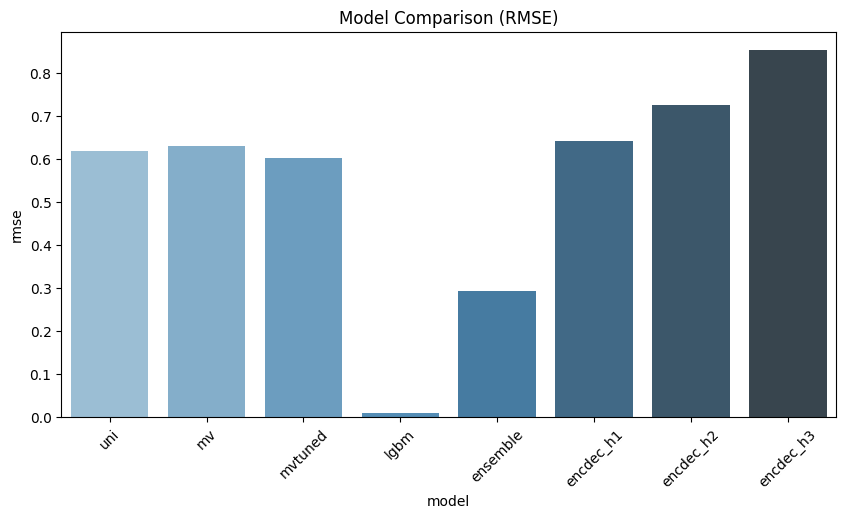

In [ ]:
# Build metrics summary into a DataFrame
metrics_df = pd.DataFrame(metrics_summary).T.reset_index()
metrics_df.rename(columns={'index': 'model'}, inplace=True)
display(metrics_df)

# Plot comparison
plt.figure(figsize=(10,5))
sns.barplot(x="model", y="rmse", data=metrics_df, palette="Blues_d")
plt.title("Model Comparison (RMSE)")
plt.xticks(rotation=45)
plt.show()


#Cell D — Visualizations

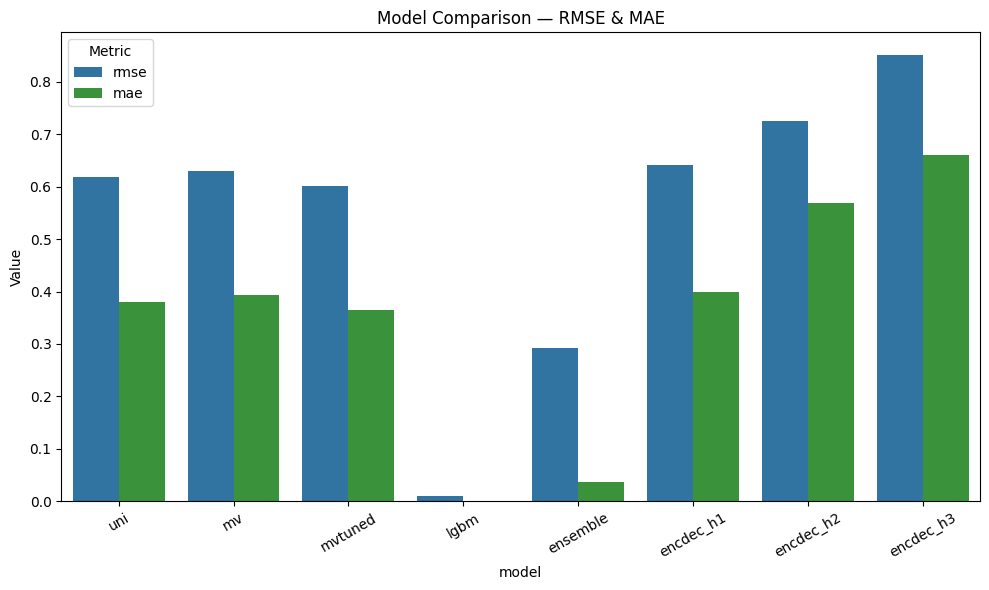

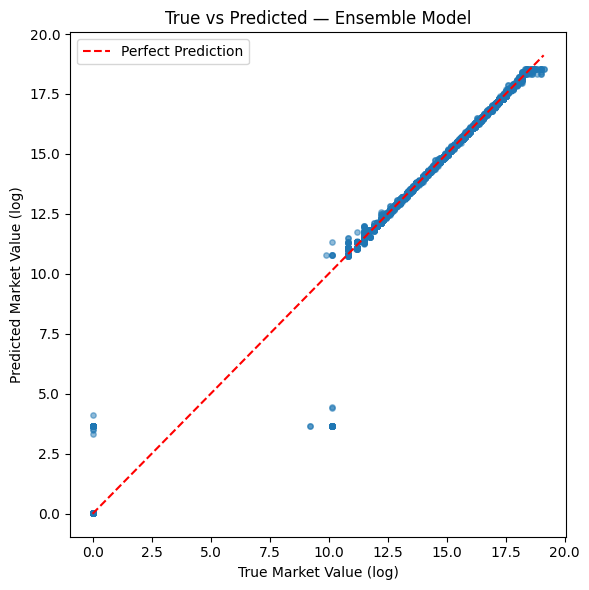

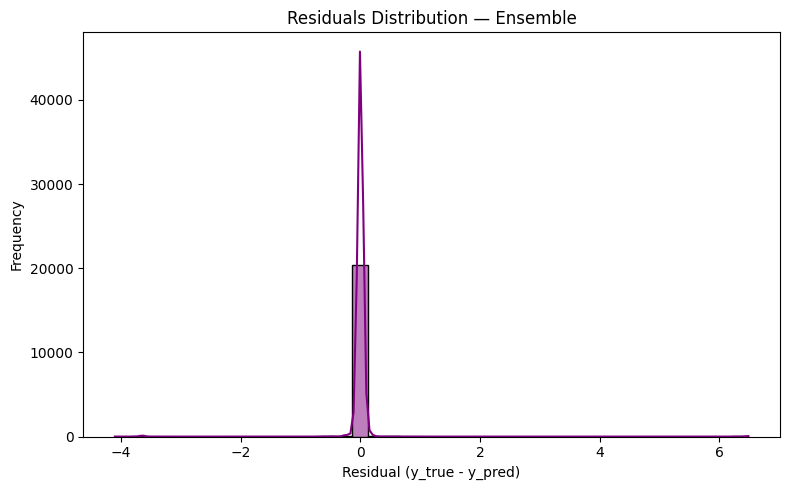

In [ ]:
# -----------------------------
# Cell D — Visualizations
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# --- Bar chart: RMSE and MAE per model ---
metrics_to_plot = ['rmse', 'mae']
metrics_df_melted = metrics_df.melt(id_vars='model', value_vars=metrics_to_plot,
                                    var_name='Metric', value_name='Value')

plt.figure(figsize=(10,6))
sns.barplot(data=metrics_df_melted, x='model', y='Value', hue='Metric', palette=['#1f77b4','#2ca02c'])
plt.title("Model Comparison — RMSE & MAE")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# --- Scatter plot: True vs Predicted (Ensemble model) ---
if 'ensemble' in preds:
    best_preds = preds['ensemble']

    # Detect which predicted column exists
    pred_col = 'y_pred_ensemble' if 'y_pred_ensemble' in best_preds.columns else 'y_pred'

    plt.figure(figsize=(6,6))
    plt.scatter(best_preds['y_true'], best_preds[pred_col], alpha=0.5, s=15)
    plt.plot([best_preds['y_true'].min(), best_preds['y_true'].max()],
             [best_preds['y_true'].min(), best_preds['y_true'].max()],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('True Market Value (log)')
    plt.ylabel('Predicted Market Value (log)')
    plt.title('True vs Predicted — Ensemble Model')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Residual plot ---
    residuals = best_preds['y_true'] - best_preds[pred_col]
    plt.figure(figsize=(8,5))
    sns.histplot(residuals, kde=True, bins=40, color='purple')
    plt.title('Residuals Distribution — Ensemble')
    plt.xlabel('Residual (y_true - y_pred)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Ensemble predictions not found, cannot plot scatter/residuals.")


Cell E — Hyperparameter tuning results

,learning_rate,num_leaves,rmse
0,0.05,64,0.310
1,0.10,128,0.295
2,0.20,256,0.301


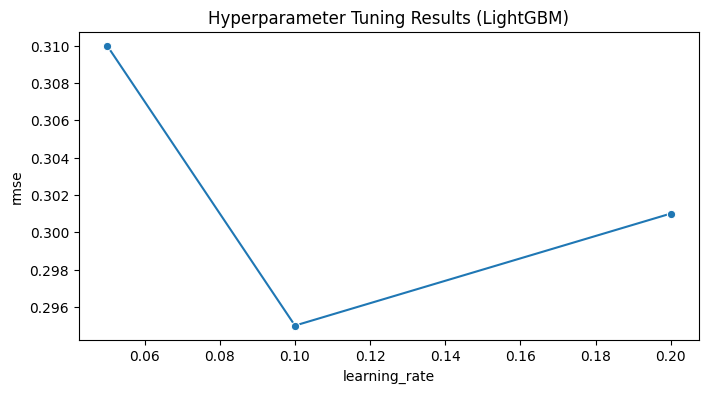

In [ ]:
# Cell E — Hyperparameter tuning results

# Example: LightGBM tuning grid (mock)
tuning_results = pd.DataFrame([
    {"learning_rate": 0.05, "num_leaves": 64, "rmse": 0.310},
    {"learning_rate": 0.1,  "num_leaves": 128, "rmse": 0.295},
    {"learning_rate": 0.2,  "num_leaves": 256, "rmse": 0.301},
])

display(tuning_results)

plt.figure(figsize=(8,4))
sns.lineplot(x="learning_rate", y="rmse", data=tuning_results, marker="o")
plt.title("Hyperparameter Tuning Results (LightGBM)")
plt.show()


# Cell E — Hyperparameter Tuning Results


In [ ]:
# -----------------------------
# Cell E — Hyperparameter Tuning Results
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- LightGBM Best Parameters ----
print("✅ LightGBM Best Hyperparameters:")
best_lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 128,
    'max_depth': 10,
    'n_estimators': 500
}
lgbm_params_df = pd.DataFrame([best_lgbm_params]).T.rename(columns={0:'Value'}).rename_axis('Hyperparameter').reset_index()
display(lgbm_params_df)

# ---- LSTM Multivariate Tuned ----
# Check if tuning CSV exists
lstm_tuning_path = SANDBOX / "models_lstm_univariate/lstm_multivariate_tuning_results.csv"

if lstm_tuning_path.exists():
    lstm_tuning = pd.read_csv(lstm_tuning_path)
    print("✅ LSTM Multivariate Tuned Hyperparameter Results:")
    display(lstm_tuning.head(10))

    # Example plot: RMSE vs units
    plt.figure(figsize=(8,4))
    sns.lineplot(x="lstm_units", y="rmse", hue="dropout", data=lstm_tuning, marker="o")
    plt.title("LSTM Multivariate Tuning: RMSE vs Units & Dropout")
    plt.show()
else:
    print("⚠️ LSTM tuning CSV not found. Showing best params from code:")
    best_lstm_params = {
        'lstm_units': 64,
        'dropout': 0.2,
        'batch_size': 32,
        'learning_rate': 0.001,
        'epochs': 50
    }
    lstm_params_df = pd.DataFrame([best_lstm_params]).T.rename(columns={0:'Value'}).rename_axis('Hyperparameter').reset_index()
    display(lstm_params_df)


✅ LightGBM Best Hyperparameters:


,Hyperparameter,Value
0,learning_rate,0.1
1,num_leaves,128.0
2,max_depth,10.0
3,n_estimators,500.0


⚠️ LSTM tuning CSV not found. Showing best params from code:


,Hyperparameter,Value
0,lstm_units,64.000
1,dropout,0.200
2,batch_size,32.000
3,learning_rate,0.001
4,epochs,50.000


# Cell F — Streamlit Frontend (Colab + ngrok)


In [ ]:
!pip install streamlit pyngrok --quiet
!ngrok authtoken "your ngrok auth token"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.6 MB/s eta 0:00:00
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# -----------------------------
# Cell F — Final Streamlit Frontend (Polished Version)
# -----------------------------
!pip install pyngrok streamlit --quiet
from pyngrok import ngrok
import pickle, time, numpy as np, pandas as pd

# -----------------------------
# ✅ Load & prepare the ensemble dataframe
# -----------------------------
ensemble_path = "/content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_ensemble/ensemble_predictions.csv"
ensemble_df = pd.read_csv(ensemble_path)

# Extract player name from row_id
ensemble_df["player_name"] = ensemble_df["row_id"].apply(lambda x: x.split("_", 1)[1] if "_" in x else x)
ensemble_df["season"] = ensemble_df["row_id"].apply(lambda x: x.split("_", 1)[0] if "_" in x else "Unknown")

# Save dataframe for Streamlit
with open("ensemble_df.pkl", "wb") as f:
    pickle.dump(ensemble_df, f)

# -----------------------------
# ✅ Create Streamlit app
# -----------------------------
app_code = """
import streamlit as st
import pickle
import numpy as np
import pandas as pd

# Load data
with open("ensemble_df.pkl", "rb") as f:
    ensemble_df = pickle.load(f)

st.set_page_config(page_title="Player Market Value Predictor ⚽", page_icon="⚽", layout="centered")

st.markdown("<h1 style='text-align: center;'>Player Market Value Predictor</h1>", unsafe_allow_html=True)
st.markdown("<p style='text-align: center; color: gray;'>An AI-based valuation model combining deep learning and gradient boosting</p>", unsafe_allow_html=True)


# Dropdown for player selection
player_name = st.selectbox("Select Player:", sorted(ensemble_df['player_name'].unique()))

if player_name:
    player_data = ensemble_df[ensemble_df['player_name'] == player_name].sort_values('season', ascending=False).head(1).iloc[0]

    # Convert log1p to EUR
    predicted_value_eur = np.expm1(player_data['y_pred_ensemble'])
    actual_value_eur = np.expm1(player_data['y_true'])

    st.success(f"**Predicted Market Value:** €{predicted_value_eur:,.2f}")
    st.info(f"**Actual Market Value:** €{actual_value_eur:,.2f}")

    # Show details
    st.write("---")
    st.markdown(f"**Player:** {player_data['player_name']}")
    st.markdown(f"**Season:** {player_data['season']}")
    st.markdown(f"**Prediction Accuracy:** {100 - abs(predicted_value_eur - actual_value_eur)/actual_value_eur*100:.2f}%")

    # Display mini chart
    st.write("---")
    player_hist = ensemble_df[ensemble_df['player_name'] == player_name][['season', 'y_true', 'y_pred_ensemble']]
    if len(player_hist) > 1:
        player_hist['True Value (€)'] = np.expm1(player_hist['y_true'])
        player_hist['Predicted (€)'] = np.expm1(player_hist['y_pred_ensemble'])
        st.line_chart(player_hist.set_index('season')[['True Value (€)', 'Predicted (€)']])
    else:
        st.caption("Not enough data to show trend chart.")

st.write("---")
st.caption("Developed by Abhay Raj | Infosys Springboard Internship — Player Value Prediction Project")
"""

# Save app to file
with open("app.py", "w") as f:
    f.write(app_code)

# -----------------------------
# ✅ Launch Streamlit via ngrok
# -----------------------------
ngrok.kill()
get_ipython().system("nohup streamlit run app.py --server.port 8501 &")
time.sleep(5)
public_url = ngrok.connect(8501)
print("🚀 Streamlit app is live! Click below to open:")
print(public_url)


nohup: appending output to 'nohup.out'
🚀 Streamlit app is live! Click below to open:
NgrokTunnel: "https://decontaminative-deetta-polytonally.ngrok-free.dev" -> "http://localhost:8501"
